# Introduction to NLP Fundamentals in TensorFlow

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-c1e969a9-1945-af76-5b8f-355269197179)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers

In [ ]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py" --quiet
from helper_functions import *

## Get a text dataset

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip" --quiet
unzip_data("nlp_getting_started.zip")

## Visualising the text dataset

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
# shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df.target.value_counts()
# i.e. fairly balanced dataset

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
print(f"# of Train Samples: {len(train_df)}\n# of Test Samples: {len(test_df)}")

# of Train Samples: 7613
# of Test Samples: 3263


In [ ]:
# visualises some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Text: {text}")
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not disaster)")
  print(100*"-")


Text: 'The first man gets the oyster the second man gets the shell.' Andrew Carnegie
Target: 0 (not disaster)
----------------------------------------------------------------------------------------------------
Text: Falling asleep to the sounds to thousands of River Plate fans in the stadium and a thunderstorm. #VivaArgentina
Target: 0 (not disaster)
----------------------------------------------------------------------------------------------------
Text: But the government will not care. Police will stop rioting eventually of protestors. Eventually some skyscrapers become plant-covered .
Target: 1 (real disaster)
----------------------------------------------------------------------------------------------------
Text: Residents in the central part of Ocean City heard from engineers about flood mitigation options Tuesday #OCNJ... http://t.co/jzPrCIqa9D
Target: 1 (real disaster)
----------------------------------------------------------------------------------------------------
Text: B

## Split data into training and validation tests

In [ ]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42
                                                                            )

In [ ]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting Text into Numbers

### Text Vectorisation (Tokenisation)

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
# <OOV> or [UNK] - out of vocabulary
# default set up below
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None,
                                    pad_to_max_tokens=None)

In [ ]:
print(f"Average Number of tokens (words in the training tweets): {round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))}")

Average Number of tokens (words in the training tweets): 15


In [ ]:
MAX_VOCAB_LENGTH = 10000 # max no of words in vocab
MAX_LENGTH = 15 # max length our seqs will be

text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB_LENGTH,
                                    output_mode="int",
                                    output_sequence_length=MAX_LENGTH)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \nVectorised version:\n{text_vectorizer([random_sentence])}")


Original text:
Its like I never left. I just sunk to the background        
Vectorised version:
[[  37   25    8  192  601    8   29  450    5    2 4120    0    0    0
     0]]


In [ ]:
# get the unique words in the vocab
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of Words in Vocab: {len(words_in_vocab)}")
print(f"Top 5 Words in Vocab: {top_5_words}")
print(f"Bottom 5 Words in Vocab: {bottom_5_words}")

Number of Words in Vocab: 10000
Top 5 Words in Vocab: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 Words in Vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Embedding

In [ ]:
from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=MAX_VOCAB_LENGTH,
                      output_dim=128,
                      input_length=MAX_LENGTH)
embedding

In [ ]:
random_sentence = random.choice(train_sentences)
embed_sentence = embedding(text_vectorizer([random_sentence]))
print(f"Original text:\n{random_sentence}\n\
      \nEmbedded version:")
embed_sentence

Original text:
When the answer my friend isn't blowing in the wind-IT'S YELLING! -How to Survive a Dust Storm http://t.co/9NwAJLi9cr http://t.co/tKMOtaeaCo
      
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01891582, -0.01187648,  0.00151783, ..., -0.01898202,
         -0.0338399 ,  0.02581281],
        [-0.01820809,  0.0173671 , -0.02749895, ..., -0.007131  ,
         -0.00391785,  0.03496473],
        [ 0.0046934 , -0.00343791,  0.02409115, ..., -0.00839015,
         -0.04405106,  0.03185766],
        ...,
        [ 0.03428665, -0.01314507, -0.02769632, ...,  0.01127815,
          0.0423652 , -0.0280272 ],
        [ 0.0352549 , -0.01231878, -0.0425176 , ..., -0.03903884,
          0.03386917, -0.00604582],
        [-0.00695124, -0.02291068,  0.0440318 , ...,  0.01221244,
         -0.01627476,  0.03986372]]], dtype=float32)>

In [ ]:
# check out a single token's embedding i.e. first word in our sentence
embed_sentence[0][0], embed_sentence[0][0].shape, random_sentence.split(" ")[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.01891582, -0.01187648,  0.00151783,  0.00502368, -0.04086246,
         0.02914152, -0.01554554,  0.03493242,  0.02932303,  0.04274623,
         0.04884933,  0.03136659,  0.02397363, -0.02645247, -0.00680766,
         0.03793916, -0.04861918, -0.04186642, -0.01624221,  0.0477694 ,
         0.00328734, -0.03726401,  0.03232462, -0.01547473, -0.00410866,
        -0.0367623 , -0.00620268,  0.01958634, -0.04384303, -0.02275397,
         0.02369264, -0.01628216,  0.0240531 , -0.04162599, -0.02450281,
         0.00300914, -0.01315447, -0.02648537,  0.00544211,  0.00996759,
        -0.034947  , -0.0034011 , -0.00380118, -0.00995495, -0.0050559 ,
        -0.01153324, -0.00191532, -0.03425508, -0.04623969, -0.01527067,
        -0.02570376, -0.00924853,  0.03471363,  0.04714825, -0.00347496,
         0.01394616,  0.03024422,  0.03012205, -0.0442985 ,  0.00640792,
        -0.00249703, -0.01866603, -0.02672275,  0.04268452, -0.02017671,
  

# Modelling a text dataset (via a series of experiments)

## Model 0: Naive-Bayes using TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB # multi-nomial niave bayes
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                   ("tfidf", TfidfVectorizer()),
                   ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline Model Accuracy: {baseline_score*100:.2f}%")

baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20], val_labels[:20]

Baseline Model Accuracy: 79.27%


(array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))

### Function to track and evaluate our models

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of binary
  classification model.
  """
  model_acc = accuracy_score(y_true, y_pred) * 100
  model_prec, model_rec, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  return {"accuracy": model_acc,
          "precision": model_prec,
          "recall": model_rec,
          "f1": model_f1}

In [ ]:
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 1: Feed-Forward Neural Network (Dense Model)

In [ ]:
SAVE_DIR = "model_logs"

In [ ]:
EXP1_NAME = "Model1_FFNN"

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name=EXP1_NAME)

model_1.summary()

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     EXP1_NAME)]
                              )

Model: "Model1_FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________
Saving TensorBoard log files to: model_logs/Model1_FFNN/20210827-205619
Epoch 1/5
215/215 [====================

In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4781 - accuracy: 0.7795


[0.4780785143375397, 0.7795275449752808]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape
# currently giving a prediction for each output token

(762, 1)

In [ ]:
# look at first 10 preds
model_1_pred_probs[:10]

array([[0.4051925 ],
       [0.8005507 ],
       [0.9977755 ],
       [0.14230508],
       [0.13045517],
       [0.9422676 ],
       [0.92623657],
       [0.9939651 ],
       [0.95078623],
       [0.31158522]], dtype=float32)

In [ ]:
# Round preds to a binary value, that are comparable to val_labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_results = calculate_results(y_true=val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 77.95275590551181,
 'f1': 0.7775281328700309,
 'precision': 0.7813761276529175,
 'recall': 0.7795275590551181}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualising Tokenisation & Embedding

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
model_1.summary()

Model: "Model1_FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# get the weight matrix of the embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights

array([[ 0.01834971,  0.05181757,  0.02475449, ...,  0.0513695 ,
         0.00957613,  0.00277995],
       [-0.04323413,  0.04534928, -0.00963314, ...,  0.00314867,
        -0.0270467 , -0.0439256 ],
       [-0.02456983,  0.02717507, -0.0337168 , ...,  0.00373281,
         0.00336235,  0.04141721],
       ...,
       [-0.01765333,  0.03844876, -0.03812904, ...,  0.00488927,
        -0.00523369,  0.04805753],
       [ 0.00544502,  0.05639428, -0.08980262, ...,  0.0759384 ,
         0.04560951,  0.0094405 ],
       [-0.09808023,  0.07000146, -0.07237264, ...,  0.0603332 ,
         0.0143438 ,  0.10215376]], dtype=float32)

In [ ]:
print(embed_weights.shape)
# same shape as vocab size and embedding_dim (output_dim of embedding layer)

(10000, 128)


In [ ]:
import io
# create embedding files
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# download colab files
#try:
#  from google.colab import files
#  files.download('vectors.tsv')
#  files.download('metadata.tsv')
#except Exception:
#  pass

##Model 2: Recurrent Neural Network - LSTM
Typically RNN structure as follows:

```
Input (text) -> Tokenise -> Embedding -> Layers (RNN/dense) -> Output (label prob)
```

In [ ]:
EXP2_NAME = "Model2_LSTM"

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # when stacking RNN cells together, need to set return_sequences to True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name=EXP2_NAME)

model_2.summary()

model_2.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     EXP2_NAME)]
)

Model: "Model2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 15, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 

In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[1.0756908e-03],
       [4.4755542e-01],
       [9.9978524e-01],
       [2.0565083e-02],
       [1.1465239e-04],
       [9.6131104e-01],
       [3.2821736e-01],
       [9.9987710e-01],
       [9.9943727e-01],
       [2.3313075e-01]], dtype=float32)

In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [ ]:
model_2_results = calculate_results(y_true=val_labels, y_pred=model_2_preds)
model_2_results

{'accuracy': 77.95275590551181,
 'f1': 0.7743583949627992,
 'precision': 0.7905327883632867,
 'recall': 0.7795275590551181}

## Model 3: Gated Recurrent Neural Network (GRU)

In [ ]:
EXP3_NAME = "Model3_GRU"

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name=EXP3_NAME)

model_3.summary()

model_3.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_3_history = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     EXP3_NAME)])

Model: "Model3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________
Saving TensorBoard log files to: model_logs/Model3_GRU/20210827-205657
Epoch 1/5
215/215 [======================

In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_results = calculate_results(y_true=val_labels, y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'f1': 0.7663871505080737,
 'precision': 0.7679905783589133,
 'recall': 0.7677165354330708}

## Model 4: Bidirectional Recurrent Neural Network

In [ ]:
EXP4_NAME = "Model3_BI_RNN"

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name=EXP4_NAME)

model_4.summary()

model_4.compile(loss="binary_crossentropy",
                metrics=["accuracy"],
                optimizer="adam")

model_4_history = model_4.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     EXP4_NAME)]) 

Model: "Model3_BI_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               74496     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,354,625
Trainable params: 1,354,625
Non-trainable params: 0
_________________________________________________________________
Saving TensorBoard log files to: model_logs/Model3_BI_RNN/20210827-205711
Epoch 1/5
215/215 [================

In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'f1': 0.7646647680054942,
 'precision': 0.7672473559947978,
 'recall': 0.7664041994750657}

## Model 5: 1D-Conv

In [ ]:
EXP5_NAME = "Model5_CONV1D"

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name=EXP5_NAME)

model_5.summary()

model_5.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_5_history = model_5.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     EXP5_NAME)]
                              )

Model: "Model5_CONV1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
___________________________________________

In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 75.8530183727034,
 'f1': 0.7564745575824241,
 'precision': 0.7596068059293093,
 'recall': 0.7585301837270341}

## Model 6: Pretrained Feature Extractor

In [ ]:
import tensorflow_hub as hub

USE_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(USE_url)
embed_samples = embed(["when you use the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples)

tf.Tensor(
[[ 2.30846200e-02 -8.58163312e-02 -1.77531615e-02  3.01210396e-03
  -2.04292983e-02 -6.96984380e-02 -5.98770566e-02  1.32916616e-02
   5.89750744e-02  7.53623620e-02 -3.45400795e-02 -2.01611426e-02
   1.77929457e-02  7.94156864e-02  6.76193759e-02 -7.28206560e-02
   1.15745356e-02 -4.10660058e-02 -3.64695638e-02  4.63266633e-02
   4.98306146e-03  3.74551490e-02  2.79740766e-02  5.41899167e-02
  -7.76213780e-02  8.55752751e-02 -1.75890997e-02 -2.37115882e-02
  -1.43646309e-02  4.63669449e-02  4.33406159e-02  1.71330515e-02
  -3.09402272e-02 -1.50807267e-02 -1.00346796e-01 -1.44574372e-02
   4.01912667e-02  5.85365929e-02  7.08232680e-03  2.21866649e-02
   1.61544327e-02 -1.04598599e-02  5.53162582e-02 -2.54815817e-02
   1.69640966e-02  2.43115015e-02 -3.28367911e-02 -6.09403662e-02
  -1.48717752e-02 -1.81527901e-02 -1.67820435e-02  2.21894179e-02
  -1.39135662e-02 -4.78068367e-02 -2.37721298e-02  6.31804159e-03
  -5.97710498e-02  5.22081628e-02  5.14192432e-02 -1.83772482e-02

In [ ]:
EXP6_NAME = "Model6_USEFeatureExtactor"
# create a keras layer using the USE pretained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(USE_url,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")
# create model using seq API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name=EXP6_NAME)


model_6.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_6.summary()

model_6_history = model_6.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     EXP6_NAME)]
                              )

Model: "Model6_USEFeatureExtactor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________
Saving TensorBoard log files to: model_logs/Model6_USEFeatureExtactor/20210827-205849
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.5047 - accuracy: 0.7777 - val_loss: 0.4569 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4160 - accuracy: 0.8155 - val_loss: 0.4386 - val

In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8142992707815864,
 'precision': 0.8151448882654851,
 'recall': 0.8149606299212598}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 7: Pretrained Feature extractor (10% of data)

### Creating subset of data

In [ ]:
# NOTE: MAKING DATA SPLITS LIKE BELOW LEADS TO DATA LEAKAGE, AS THE NEW 10% OF
# TRAINING DATA WILL CONTAIN PARTS OF THE VALIDATION DATASET, HENCE WHY IT HAS
# THEN OUTPERFORMED MODEL 6

# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].tolist()
# train_labels_10_percent = train_10_percent["target"].tolist()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [ ]:
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Training model 6 on subset of data

In [ ]:
EXP7_NAME = "Model7_FeatExtractor_10_perc_data"

model_7 = tf.keras.models.clone_model(model_6)
model_7._name = EXP7_NAME

model_7.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_7.summary()

model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     EXP7_NAME)]
)

Model: "Model7_FeatExtractor_10_perc_data"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________
Saving TensorBoard log files to: model_logs/Model7_FeatExtractor_10_perc_data/20210827-205937
Epoch 1/5
22/22 [==============================] - 5s 135ms/step - loss: 0.6732 - accuracy: 0.6774 - val_loss: 0.6511 - val_accuracy: 0.7572
Epoch 2/5
22/22 [==============================] - 1s 46ms/step - loss: 0.6010 - accuracy: 0.8161 - val_loss:

In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.21522309711287,
 'f1': 0.7805300645444495,
 'precision': 0.7833242410577732,
 'recall': 0.7821522309711286}

In [ ]:
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8142992707815864,
 'precision': 0.8151448882654851,
 'recall': 0.8149606299212598}

>

## Comparing Models

In [ ]:
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simpledense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results, 
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_USE": model_6_results,
                                  "7_USE_10_percent": model_7_results
                                  })
all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simpledense,0.779528,0.781376,0.779528,0.777528
2_lstm,0.779528,0.790533,0.779528,0.774358
3_gru,0.767717,0.767991,0.767717,0.766387
4_bidirectional,0.766404,0.767247,0.766404,0.764665
5_conv1d,0.758530,0.759607,0.758530,0.756475
6_USE,0.814961,0.815145,0.814961,0.814299
7_USE_10_percent,0.782152,0.783324,0.782152,0.780530


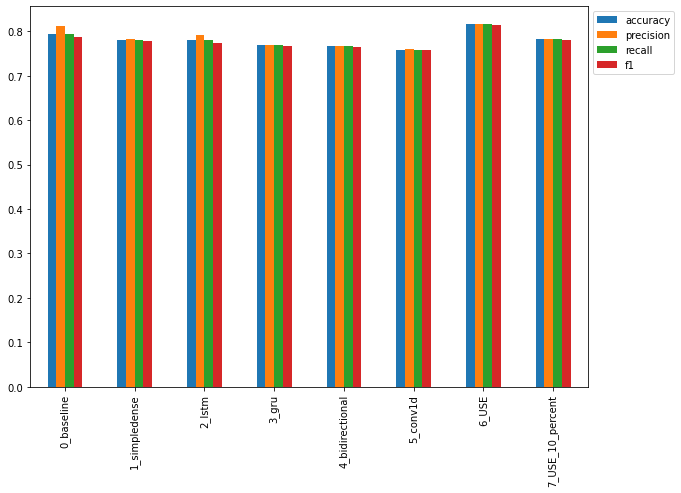

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

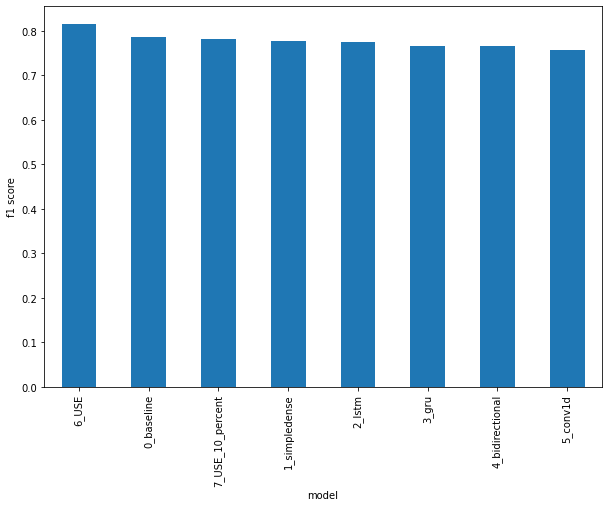

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7), xlabel="model", ylabel="f1 score");

## Upload to TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./model_logs/ \
--name "NLP Modelling Experiments on Disaster Tweet Dataset" \
--description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
--one_shot

[TensorBoard Project](https://tensorboard.dev/experiment/Bgarswv2S8WnzoLxYsAAzg/#scalars)

## Saving our best model

In [ ]:
model_6.save("model_6.h5")

In [ ]:
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4287 - accuracy: 0.8150


[0.4287000894546509, 0.8149606585502625]

In [ ]:
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [ ]:
loaded_model_6 = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4287 - accuracy: 0.8150


[0.42870011925697327, 0.8149606585502625]

## Finding the most wrong examples

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip" --quiet
!unzip 08_model_6_USE_feature_extractor.zip

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.index  
  inflating: 08_model_6_USE_feature_extractor/saved_model.pb  


In [ ]:
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [ ]:
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))

In [ ]:
val_df = pd.DataFrame({
    "text": val_sentences,
    "target": val_labels,
    "pred": model_6_pretrained_preds,
    "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)
})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
most_wrong = val_df[ val_df["target"] != val_df["pred"] ]
most_wrong["error"] = (val_df["target"] - val_df["pred_prob"]).abs()

most_wrong = most_wrong.sort_values("error", ascending=False)
most_wrong.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,target,pred,pred_prob,error
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186,0.962814
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949,0.961051
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998,0.961002
233,I get to smoke my shit in peace,1,0.0,0.042087,0.957913
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918,0.956082


## Making predictions on the test dataset

In [ ]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text: {test_sample}")
  print(50*"-")

Pred: 1, Prob: 0.6442501544952393
Text: A Dog Was Abandoned In A Thunderstorm. But Then A Neighbor Steps Up And Does THIS http://t.co/iR3OXEH7id
--------------------------------------------------
Pred: 0, Prob: 0.32822707295417786
Text: A Sinkhole caved in a Brooklyn Street today on 5th Ave &amp; 64th Street. http://t.co/eUKhLKgGdO
--------------------------------------------------
Pred: 0, Prob: 0.2568259537220001
Text: But the ceiling and the walls collapsed. Upon the darkness I was trapped.
--------------------------------------------------
Pred: 1, Prob: 0.8192915320396423
Text: RT RTphotographyUK: New #photo Oak in a snowstorm http://t.co/gWOKZELq5Q taken in #winter on the #SouthDowns #Hampshire #photography #artÛ_
--------------------------------------------------
Pred: 0, Prob: 0.29522278904914856
Text: @megynkelly illegals don't abide by the uniform building codes or OSHA safety codes.structur's they build are hazardous to your health.
-----------------------------------------

## The speed-score tradeoff

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8142992707815864,
 'precision': 0.8151448882654851,
 'recall': 0.8149606299212598}

In [ ]:
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make preds on samples.
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time / len(samples)
  return total_time, time_per_pred

In [ ]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.3514527550000821, 0.00046122408792661693)

In [ ]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0,
                                                            samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.021578329000021768, 2.831801706039602e-05)

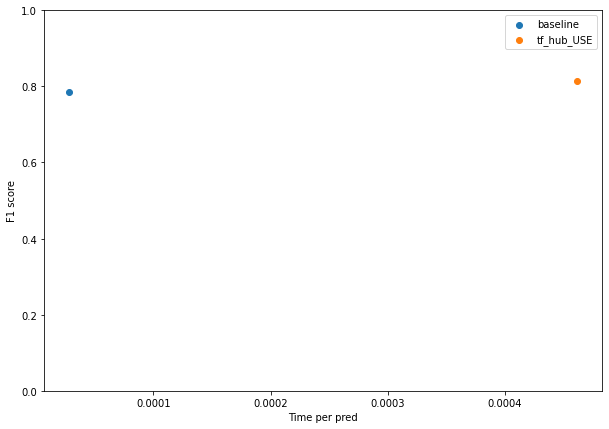

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_USE")
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Time per pred")
plt.ylabel("F1 score")
plt.show()